In [143]:
from xgboost import XGBRegressor
from xgboost import plot_importance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import feature_selection
from sklearn.model_selection import RandomizedSearchCV
import shap

/Users/kaushikbalantrapu/Projects/SolarPanelOutputPrediction/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
# get data from csv, load into dataframe, show first 5 entries
df = pd.read_csv('solarPanelDataset.csv', index_col=False)
print(df.head())

      Location      Date  Time  Latitude  Longitude  Altitude    YRMODAHRMI  \
0  Camp Murray  20171203  1145     47.11    -122.57        84  2.017120e+11   
1  Camp Murray  20171203  1315     47.11    -122.57        84  2.017120e+11   
2  Camp Murray  20171203  1330     47.11    -122.57        84  2.017120e+11   
3  Camp Murray  20171204  1230     47.11    -122.57        84  2.017120e+11   
4  Camp Murray  20171204  1415     47.11    -122.57        84  2.017120e+11   

   Month  Hour  Season  Humidity  AmbientTemp  PolyPwr  Wind.Speed  \
0     12    11  Winter  81.71997     12.86919  2.42769           5   
1     12    13  Winter  96.64917      9.66415  2.46273           0   
2     12    13  Winter  93.61572     15.44983  4.46836           5   
3     12    12  Winter  77.21558     10.36659  1.65364           5   
4     12    14  Winter  54.80347     16.85471  6.57939           3   

   Visibility  Pressure  Cloud.Ceiling  
0        10.0    1010.6            722  
1        10.0    1011.

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21045 entries, 0 to 21044
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       21045 non-null  object 
 1   Date           21045 non-null  int64  
 2   Time           21045 non-null  int64  
 3   Latitude       21045 non-null  float64
 4   Longitude      21045 non-null  float64
 5   Altitude       21045 non-null  int64  
 6   YRMODAHRMI     21045 non-null  float64
 7   Month          21045 non-null  int64  
 8   Hour           21045 non-null  int64  
 9   Season         21045 non-null  object 
 10  Humidity       21045 non-null  float64
 11  AmbientTemp    21045 non-null  float64
 12  PolyPwr        21045 non-null  float64
 13  Wind.Speed     21045 non-null  int64  
 14  Visibility     21045 non-null  float64
 15  Pressure       21045 non-null  float64
 16  Cloud.Ceiling  21045 non-null  int64  
dtypes: float64(8), int64(7), object(2)
memory usage: 2

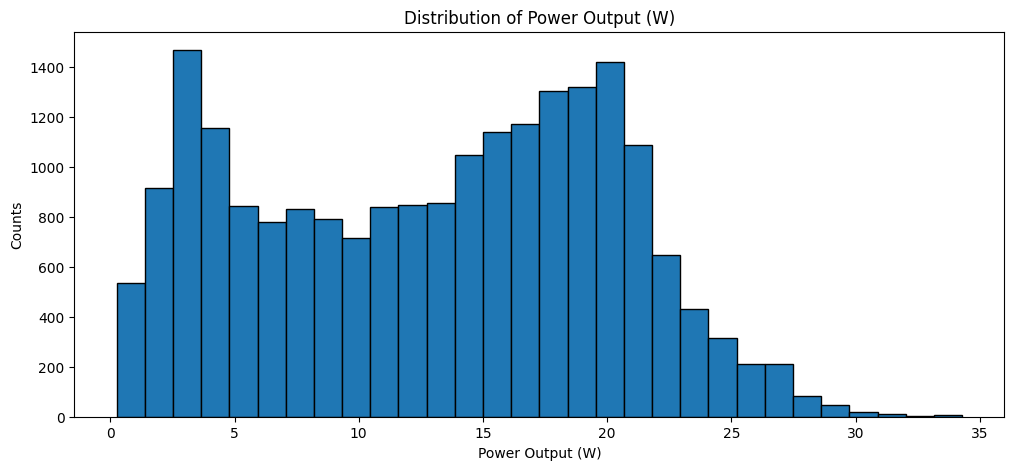

In [48]:
plt.figure(figsize=(12, 5))
plt.hist(df.PolyPwr, bins = 30, histtype='bar', ec='black')
plt.xlabel('Power Output (W)')
plt.ylabel('Counts')
plt.title('Distribution of Power Output (W)')
plt.show()

<Axes: >

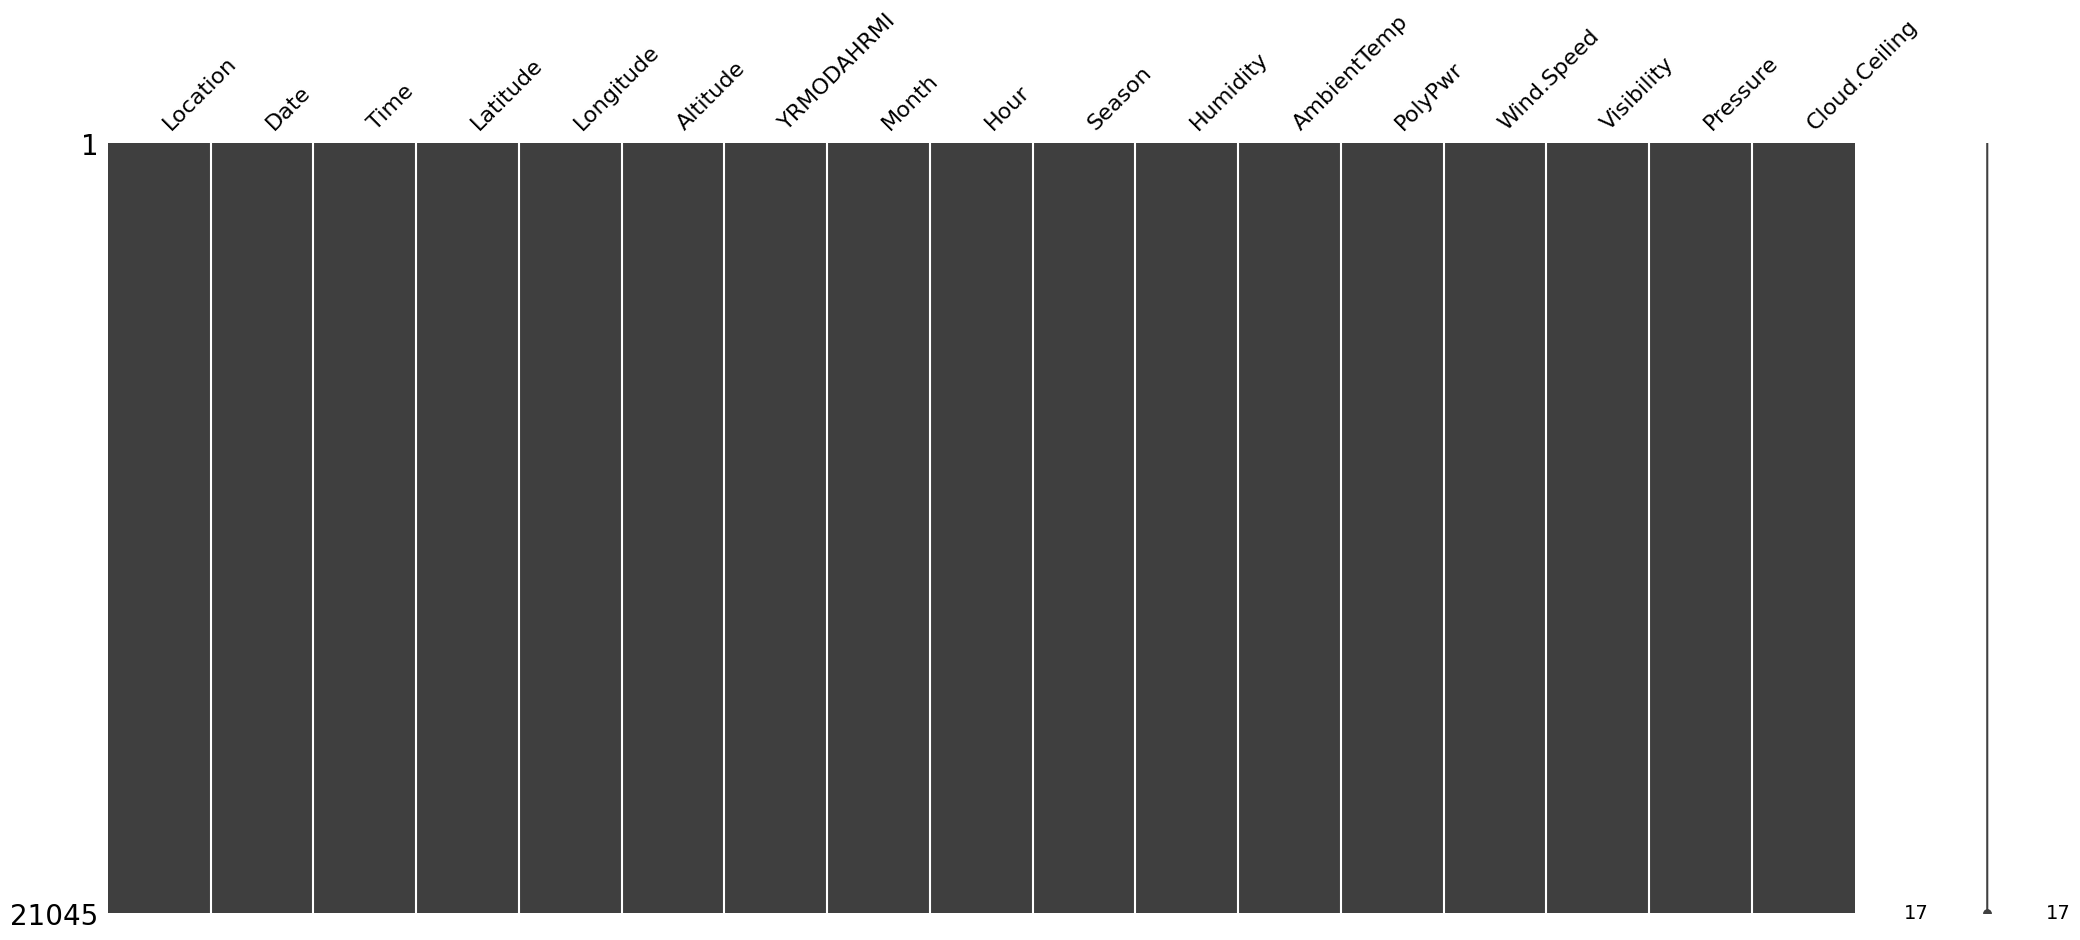

In [49]:
msno.matrix(df)

In [50]:
df_temp = df[['Location', 'Time', 'Latitude', 'Longitude', 'Altitude',
              'YRMODAHRMI', 'Month', 'Hour', 'Season', 'Humidity', 'AmbientTemp',
              'Wind.Speed', 'Visibility', 'Pressure', 'Cloud.Ceiling', 'PolyPwr']]

df_temp = df_temp.corr(method='pearson', numeric_only = True)


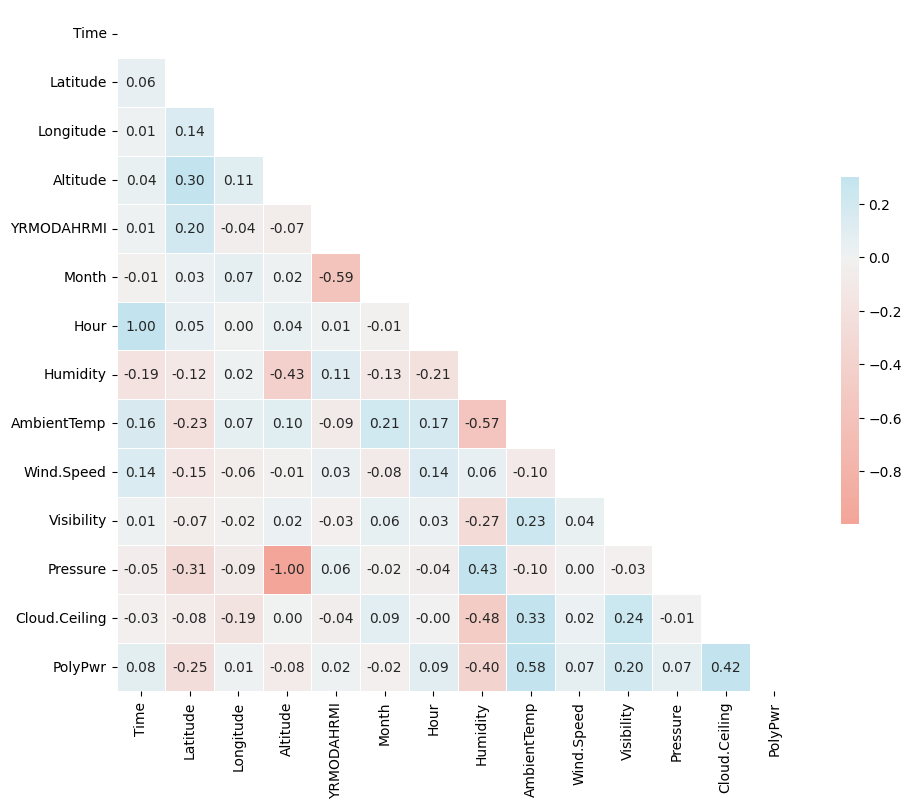

In [51]:
mask = np.triu(np.ones_like(df_temp, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 220, s = 80, l = 75, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_temp, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={'shrink': .5})

plt.show()

In [52]:
independentVarsDf = df.drop(labels=(['Location', 'PolyPwr', 'Season']), axis=1)
dependentVarsDf = df['PolyPwr']
#X_train, X_test, Y_train, Y_test = train_test_split(currentDf.loc[:, np.logical_and(df.columns != 'PolyPwr', df.columns != '#')], currentDf['PolyPwr'], test_size=0.3)
#currentDf = currentDf.loc[:, (currentDf.columns != 'PolyPwr' & currentDf.columns != 'Season').all()]
#X_train, X_test, Y_train, Y_test = train_test_split(currentDf.loc[:, (currentDf.columns != 'PolyPwr' and currentDf.columns != 'Season').all()], currentDf['PolyPwr'], test_size=0.3)
X_train, X_test, Y_train, Y_test = train_test_split(independentVarsDf, dependentVarsDf, test_size=0.2)

In [151]:
reg = XGBRegressor(booster='gbtree')

In [152]:
reg.fit(X_train, Y_train, eval_set=[(X_test, Y_test)])

[0]	validation_0-rmse:12.98912
[1]	validation_0-rmse:11.86673
[2]	validation_0-rmse:10.87602
[3]	validation_0-rmse:9.99410
[4]	validation_0-rmse:9.21351
[5]	validation_0-rmse:8.52845
[6]	validation_0-rmse:7.92591
[7]	validation_0-rmse:7.39927
[8]	validation_0-rmse:6.94417
[9]	validation_0-rmse:6.54852
[10]	validation_0-rmse:6.20574
[11]	validation_0-rmse:5.91285
[12]	validation_0-rmse:5.66012
[13]	validation_0-rmse:5.44726
[14]	validation_0-rmse:5.26789
[15]	validation_0-rmse:5.11081
[16]	validation_0-rmse:4.97656
[17]	validation_0-rmse:4.86745
[18]	validation_0-rmse:4.77101
[19]	validation_0-rmse:4.69360
[20]	validation_0-rmse:4.62726
[21]	validation_0-rmse:4.57275
[22]	validation_0-rmse:4.52123
[23]	validation_0-rmse:4.47982
[24]	validation_0-rmse:4.44325
[25]	validation_0-rmse:4.41109
[26]	validation_0-rmse:4.38438
[27]	validation_0-rmse:4.36291
[28]	validation_0-rmse:4.34555
[29]	validation_0-rmse:4.32762
[30]	validation_0-rmse:4.31595
[31]	validation_0-rmse:4.29903
[32]	validation

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

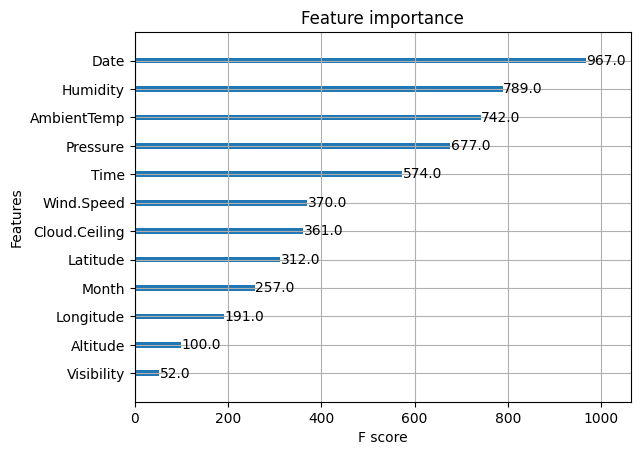

In [153]:
plot_importance(reg)
plt.show()

In [154]:
predictions = reg.predict(X_test)

In [155]:
reg.score(X_test, Y_test) * 100

66.233209190825

In [156]:
rmse = np.sqrt(mean_squared_error(Y_test, predictions))
print(f'RMSE: {rmse:.6}')

RMSE: 4.13059


In [157]:
r2Score = r2_score(Y_test, predictions)
print(f'r-squared score: {r2Score:.6}')

r-squared score: 0.662332


In [60]:
feature_selection.f_classif(X_test, Y_test)

(array([1.4439448 , 0.99475274, 2.65247583, 2.23828634, 3.8044889 ,
        1.44309138, 0.62318976, 0.99445158, 1.72913758, 3.96799006,
        1.10811712, 0.27224029, 3.53163415, 1.00002397]),
 array([9.51748446e-04, 5.32466256e-01, 1.30633579e-14, 6.25219658e-11,
        1.15288489e-23, 9.67241800e-04, 9.99998191e-01, 5.33554818e-01,
        3.03106025e-06, 8.20902300e-25, 1.89838578e-01, 1.00000000e+00,
        1.11906401e-21, 5.13450013e-01]))

In [61]:
'''
# new base model
reg2 = XGBRegressor(objective='reg:squarederror',
                    nthread = 4,
                    silent = 0)

# define search space
params = {
	        'num_boost_round': [10, 25, 5, 15],
	        'eta': [0.05, 0.001, 0.1, 0.3],
	        'max_depth': [3, 6, 4, 5],
	        'subsample': [0.9, 1.0, 0.8],
	        'colsample_bytree': [0.9, 1.0, 0.8],
	        'alpha': [0.1, 0.3, 0.0]
	    }
# define search
randomSearch = RandomizedSearchCV(reg2, params, n_jobs=-1, cv=5, n_iter=500, verbose=1, scoring='r2')

# execute search
randomSearch.fit(X_train, Y_train, verbose=True)
bestParameters = randomSearch.best_params_

# print results
print('RandomizedSearchCV Results: ')
print(randomSearch.best_score_)
print('Best Parameters: ')
for param_name in sorted(bestParameters.keys()):
	print("%s: %r" % (param_name, bestParameters[param_name]))
print('Best Estimator: ')
print(randomSearch.best_estimator_)
y_pred = randomSearch.predict(X_test)
'''

'\n# new base model\nreg2 = XGBRegressor(objective=\'reg:squarederror\',\n                    nthread = 4,\n                    silent = 0)\n\n# define search space\nparams = {\n\t        \'num_boost_round\': [10, 25, 5, 15],\n\t        \'eta\': [0.05, 0.001, 0.1, 0.3],\n\t        \'max_depth\': [3, 6, 4, 5],\n\t        \'subsample\': [0.9, 1.0, 0.8],\n\t        \'colsample_bytree\': [0.9, 1.0, 0.8],\n\t        \'alpha\': [0.1, 0.3, 0.0]\n\t    }\n# define search\nrandomSearch = RandomizedSearchCV(reg2, params, n_jobs=-1, cv=5, n_iter=500, verbose=1, scoring=\'r2\')\n\n# execute search\nrandomSearch.fit(X_train, Y_train, verbose=True)\nbestParameters = randomSearch.best_params_\n\n# print results\nprint(\'RandomizedSearchCV Results: \')\nprint(randomSearch.best_score_)\nprint(\'Best Parameters: \')\nfor param_name in sorted(bestParameters.keys()):\n\tprint("%s: %r" % (param_name, bestParameters[param_name]))\nprint(\'Best Estimator: \')\nprint(randomSearch.best_estimator_)\ny_pred = ra

In [321]:
regOptimized = XGBRegressor(alpha=0.19, colsample_bytree=0.9, eta=0.07, max_depth=8, n_estimators=125, num_boost_round=15, subsample=0.8)

In [322]:
regOptimized.fit(X_train, Y_train, eval_set=[(X_test, Y_test)])

[17:22:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[0]	validation_0-rmse:13.36096
[1]	validation_0-rmse:12.53650
[2]	validation_0-rmse:11.77558
[3]	validation_0-rmse:11.07319
[4]	validation_0-rmse:10.42887
[5]	validation_0-rmse:9.83527
[6]	validation_0-rmse:9.29135
[7]	validation_0-rmse:8.79046
[8]	validation_0-rmse:8.33262
[9]	validation_0-rmse:7.91089
[10]	validation_0-rmse:7.52465
[11]	validation_0-rmse:7.17443
[12]	validation_0-rmse:6.85573
[13]	validation_0-rmse:6.56886
[14]	validation_0-rmse:6.30738
[15]	validation_0-rmse:6.06955
[16]	validation_0-rmse:5.85607
[17]	validation_0-rmse:5.66693
[18]	validation_0-rmse:5.49530
[19]	validation_0-rmse:5.34072
[20]	validation_0-rmse:5.20388
[21]	validation_0-rmse:5.07863
[22]	validation_0-rmse:4.96700
[23]	validation_0-rmse:4.86698
[24]	validation_0-rmse:4.77924
[25]	validation_0-rmse:4.69823
[26]	valida

XGBRegressor(alpha=0.19, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eta=0.07, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=125, n_jobs=None,
             num_boost_round=15, ...)

In [323]:
predictions2 = regOptimized.predict(X_test)

In [324]:
r2Score = r2_score(Y_test, predictions2)
print(f'r-squared score: {r2Score:.6f}')

r-squared score: 0.676909


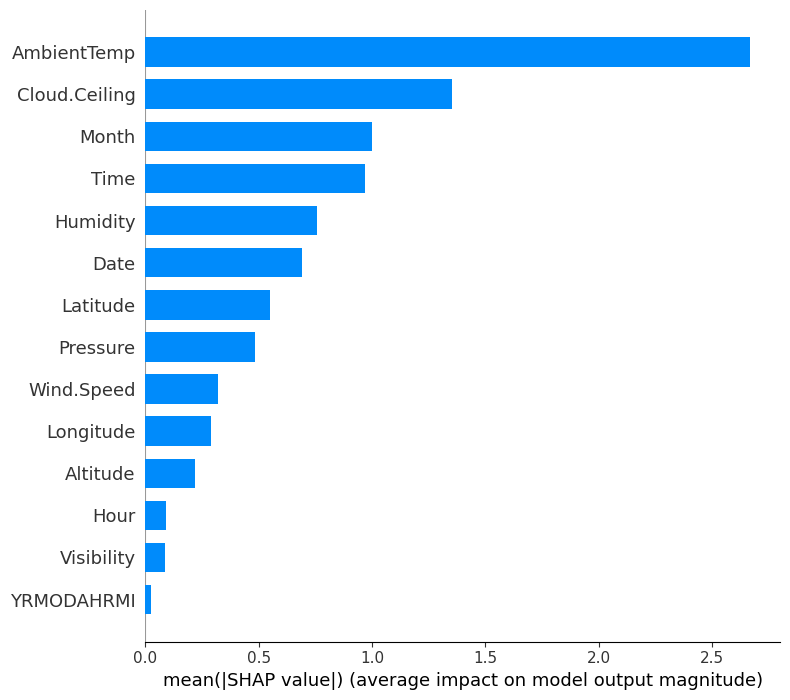

In [159]:
shap_values = shap.TreeExplainer(regOptimized).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')
plt.show()